# SAR example
Let's use EOReader with SAR data.

<div class="alert alert-warning">
  
<strong>Warning:</strong> SAR data is processed with <a href="https://step.esa.int/main/download/snap-download/">SNAP</a>, so be sure to have it installed and that <code>GPT</code> is in your path. 
    
</div>


## Imports

In [1]:
import os
import matplotlib.pyplot as plt

# EOReader
from eoreader.reader import Reader
from eoreader.bands import VV, HH, VV_DSPK, HH_DSPK, HILLSHADE, SLOPE, to_str
from eoreader.env_vars import DEM_PATH

## Create logger

In [2]:
# Create logger
import logging
from sertit import logs

logger = logging.getLogger("eoreader")
logs.init_logger(logger)

## Open the COSMO-SkyMed product

Please be aware that:
- **EOReader** will orthorectify your SAR data to get UTM tiles.
- complex data is not handled as is, **EOReader** will convert them to ground range.

In [3]:
# First of all, we need some VHR data, let's use some COSMO-SkyMed data
path = os.path.join("/home", "data", "DATA", "PRODS", "COSMO", "1st_GEN", "1001512-735097")

# Open your product
prod = Reader().open(path, remove_tmp=True)
prod

eoreader.CskProduct 'CSKS4_DGM_B_HI_09_HH_RA_FF_20201008224018_20201008224025'
Attributes:
	condensed_name: 20201008T224018_CSK_HH_HI_DGM
	path: /home/data/DATA/PRODS/COSMO/1st_GEN/1001512-735097
	constellation: COSMO-SkyMed
	sensor type: SAR
	product type: DGM
	default pixel size: 2.5
	default resolution: 5.0
	acquisition datetime: 2020-10-08T22:40:18.446381
	band mapping:
		HH: HH
		HH_DSPK: HH_DSPK
	needs extraction: True
	orbit direction: ASCENDING

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/conda/lib/python3.10/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This beh

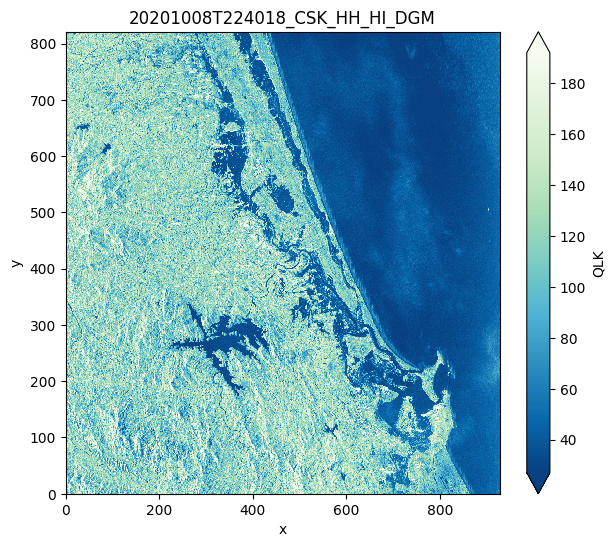

In [4]:
# Plot the quicklook
prod.plot()

In [5]:
# Get the band information
prod.bands

eoreader.SarBand 'HH'
Attributes:
	id: HH
	eoreader_name: HH
	gsd (m): 2.5
	asset_role: intensity
eoreader.SarBand 'HH_DSPK'
Attributes:
	id: HH_DSPK
	eoreader_name: HH_DSPK
	gsd (m): 2.5
	asset_role: intensity

In [6]:
# Print some data
print(f"Acquisition datetime: {prod.datetime}")
print(f"Condensed name: {prod.condensed_name}")

# Open here some more interesting geographical data: extent and footprint
extent = prod.extent()
footprint = prod.footprint()

base = extent.plot(color='cyan', edgecolor='black')
footprint.plot(ax=base, color='blue', edgecolor='black', alpha=0.5)

Acquisition datetime: 2020-10-08 22:40:18.446381
Condensed name: 20201008T224018_CSK_HH_HI_DGM


/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
2023-05-31 11:47:25,746 - [DEBUG] - Pre-process SAR image


SNAP Release version 9.0.0
SNAP home: /opt/snap/bin/..
SNAP debug: null
SNAP log level: WARNING
Java home: /opt/snap/jre/jre
Java version: 1.8.0_242
Processors: 16
Max memory: 40.9 GB
Cache size: 23.0 GB
Tile parallelism: 14
Tile size: 512 x 512 pixels

To configure your gpt memory usage:
Edit snap/bin/gpt.vmoptions

To configure your gpt cache size and parallelism:
Edit .snap/etc/snap.properties or gpt -c ${cachesize-in-GB}G -q ${parallelism} 
Executing processing graph
Copernicus_DSM_COG_10_N15_00_E108_00_DEM.tif
....10%.

Killed


RuntimeError: Something went wrong with SNAP!

For SAR data, the footprint needs the orthorectified data !
For that, SNAP uses its own DEM, but you can change it when positionning the `EOREADER_SNAP_DEM_NAME` environment variable. 
Available DEMs are:
- `ACE2_5Min` 
- `ACE30`
- `ASTER 1sec GDEM`
- `Copernicus 30m Global DEM`
- `Copernicus 90m Global DEM`
- `GETASSE30`
- `SRTM 1Sec HGT`
- `SRTM 3Sec`
- `External DEM`

<div class="alert alert-warning">
  
<strong>Warning:</strong> 
   If `External DEM` is set, you must specify the DEM you want by positioning the `EOREADER_DEM_PATH` to a DEM that can be read by SNAP.
</div>
    
## Load bands

In [ ]:
# Set the DEM
os.environ[DEM_PATH] = os.path.join("/home", "data", "DS2", "BASES_DE_DONNEES", "GLOBAL", "COPDEM_30m", "COPDEM_30m.vrt")

# Select some bands you wish to load without knowing if they exist
bands = [VV, HH, VV_DSPK, HH_DSPK, HILLSHADE, SLOPE]

# Only keep those selected
ok_bands = [band for band in bands if prod.has_band(band)]

# This product does not have VV band and HILLSHADE band cannot be computed from SAR band
print(to_str(ok_bands))

In [ ]:
# Load those bands as a xarray.Dataset, with a 20m pixel size
band_ds = prod.load(ok_bands, pixel_size=20.)
band_ds[HH]

<div class="alert alert-info">
Some SAR band (i.e. COSMO) may contain null pixels that are not really nodata (but very low values like water).  
    
This can lead the <code>Terrain Correction</code> step to create large nodata area when projecting on a DEM.
    
If it happens, you can set the keyword <code>SAR_INTERP_NA</code> to <code>True</code> when loading or stacking SAR data to fill these area with interpolated data.
</div>

```python
from eoreader.keywords import SAR_INTERP_NA
band_dict = prod.load(
    ok_bands, 
    pixel_size=20.,
    **{SAR_INTERP_NA: True}
)
```

In [ ]:
# Plot a subsampled version
band_ds[SLOPE][:, ::10, ::10].plot()

## Stack some data

In [ ]:
# You can also stack those bands
stack = prod.stack(ok_bands)
stack

In [ ]:
# Plot a subsampled version
nrows = len(stack)
fig, axes = plt.subplots(nrows=nrows, figsize=(3 * nrows, 6 * nrows), subplot_kw={"box_aspect": 1})

for i in range(nrows):
    stack[i, ::10, ::10].plot(x="x", y="y", ax=axes[i])